In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

FIG_SIZE = (10, 8)
FONT_SIZE = "22"
FONT_WEIGHT = "bold"
MARKER_SIZE = 10
LINE_WIDTH = 2
GRID = True
Y_LIM_ET = (0, 1800)
Y_LIM_TPF = (0, 225)
Y_SCALE = "linear"

rc = {
    "figure.figsize": FIG_SIZE, "figure.titlesize": 20,
    "axes.labelsize": FONT_SIZE, "axes.labelweight": FONT_WEIGHT,
    "legend.fontsize": FONT_SIZE, "legend.title_fontsize": FONT_SIZE,
    "xtick.labelsize": FONT_SIZE, "ytick.labelsize": FONT_SIZE,
    "lines.markersize": MARKER_SIZE, "lines.linewidth": LINE_WIDTH,
    "axes.grid": GRID,
}

sns.set_theme(style="whitegrid", palette="colorblind", context="paper", rc=rc)

In [7]:
import pandas as pd
import numpy as np
from pathlib import Path

df = pd.read_parquet('../results/scalability.parquet')
NODES = sorted(list(df["Nodes"].unique()))
NODES = [str(n) for n in NODES]
df["RepProb"] = df["RepProb"].astype(str)
df.shape

(8400, 15)

In [8]:
df_t = df[df['Output'].isin(['timeout'])]
df_t.shape

(3950, 15)

In [9]:
# Compute average timeout ratio per topology, version, rep prob, nodes, flows
TOPOLOGIES = df["Topology"].unique()
df2 = df_t.copy()
group_by = ["Topology", "RepProb", "Nodes", "Flows"]
df_nodes = df.groupby(group_by).size().reset_index(name="Count")
df_nodes.set_index(group_by, inplace=True)
df2_nodes = df2.groupby(group_by).size().reset_index(name="TimeoutCount")
df2_nodes.set_index(group_by, inplace=True)
df_merged = df_nodes.join(df2_nodes, how="left").fillna(0)
df_merged["TimeoutRatio"] = df_merged["TimeoutCount"] / df_merged["Count"] * 100
df_merged.reset_index(inplace=True)

In [10]:
# df_merged = df_merged[(df_merged["Flows"] == 500 ) | (df_merged["Flows"] % 2000 == 0)]
df_merged = df_merged[["Topology", "RepProb", "Nodes", "Flows", "TimeoutRatio"]]

for topo in TOPOLOGIES:
    df_topo = df_merged[df_merged["Topology"] == topo]
    df_topo = df_topo.groupby(["Flows", "RepProb"])["TimeoutRatio"].mean().reset_index()
    df_topo["TimeoutRatio"] = df_topo["TimeoutRatio"].round(2)
    df_topo.to_csv(f'../results/scalability_timeoutratio_{topo}.csv', index=False)

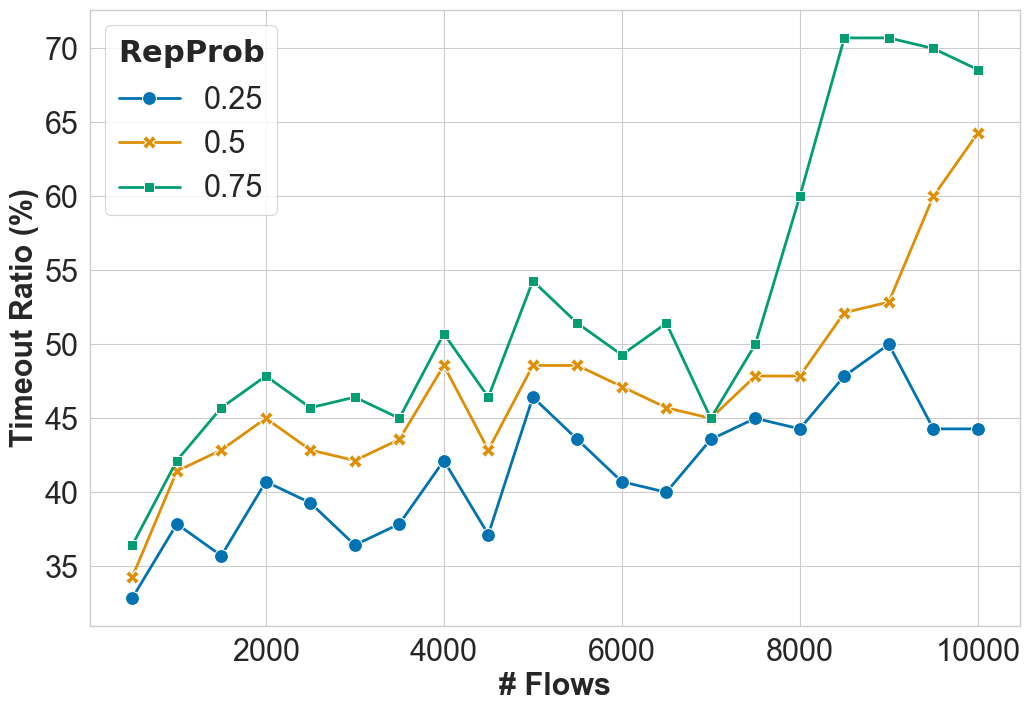

In [11]:
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=df_merged,
    x="Flows",
    y="TimeoutRatio",
    hue="RepProb",
    style="RepProb",
    markers=True,
    dashes=False,
    errorbar=None,
)

plt.xlabel("# Flows")
plt.ylabel("Timeout Ratio (%)")
plt.legend(title=r'$\bf{RepProb}$')
plt.grid(True)
plt.show()